# Testing affected districts at landfall

In [ ]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [ ]:
import matplotlib.pyplot as plt
import json
from shapely.geometry import Point, Polygon

from src.datasources import codab
from src.constants import *
from src.utils import *

In [20]:
adm2 = codab.load_codab(admin_level=2)

In [21]:
# file from Meteo-France
forecast_path = (
    "../forecasts/CMRSTRACK_SWI$04_20242025_CHIDO_2024_12_15_02Z.json"
)
with open(forecast_path, "r") as file:
    data = json.load(file)

In [22]:
forecast_data = None
for feature in data["features"]:
    if (
        feature["properties"]["data_type"] == "forecast"
        and feature["properties"]["time"] == "2024-12-15T00:00:00Z"
    ):
        forecast_data = feature
    if (
        feature["properties"]["data_type"] == "forecast"
        and feature["properties"]["time"] == "2024-12-15T12:00:00Z"
    ):
        next_forecast_point_data = feature
    if feature["properties"]["data_type"] == "uncertainty_cone":
        uncertainty_cone = feature["geometry"]

wind_contours = forecast_data["properties"]["cyclone_data"]["wind_contours"]
# distance = cyclone_center.distance(next_forecast_point)

In [23]:
cyclone_center = Point(
    forecast_data["geometry"]["coordinates"][0],
    forecast_data["geometry"]["coordinates"][1],
)
cyclone_centre_speed = forecast_data["properties"]["cyclone_data"][
    "maximum_wind"
]["wind_speed_kt"]
next_forecast_point = Point(
    next_forecast_point_data["geometry"]["coordinates"][0],
    next_forecast_point_data["geometry"]["coordinates"][1],
)
next_forecast_point_speed = next_forecast_point_data["properties"][
    "cyclone_data"
]["maximum_wind"]["wind_speed_kt"]
cone_polygon = Polygon(uncertainty_cone["coordinates"][0])

In [ ]:
def generate_truncated_cones(
    cyclone_centre_speed,
    next_forecast_point_speed,
    thresholds,
    uncertainty_cone,
):

    truncated_cones = []
    for threshold in thresholds:
        if (
            cyclone_centre_speed > threshold
            and next_forecast_point_speed < threshold
        ):
            t = (cyclone_centre_speed - threshold) / (
                cyclone_centre_speed - next_forecast_point_speed
            )

            interpolated_x = cyclone_center.x + t * (
                next_forecast_point.x - cyclone_center.x
            )
            interpolated_y = cyclone_center.y + t * (
                next_forecast_point.y - cyclone_center.y
            )
            truncation_point = Point(interpolated_x, interpolated_y)

            buffer_radius = cyclone_center.distance(truncation_point)
            buffer = cyclone_center.buffer(buffer_radius)

            truncated_cone = cone_polygon.intersection(buffer)
        else:
            truncation_point = None
            truncated_cone = None
        truncated_cones.append(truncated_cone)

    return truncated_cones


truncated_cones = generate_truncated_cones(
    cyclone_centre_speed=cyclone_centre_speed,
    next_forecast_point_speed=next_forecast_point_speed,
    thresholds=[48, 64],
    uncertainty_cone=uncertainty_cone,
)
truncated_cone_48kt = truncated_cones[0]
truncated_cone_64kt = truncated_cones[1]

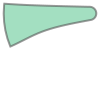

In [25]:
truncated_cone_48kt

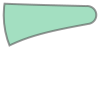

In [26]:
truncated_cone_64kt

In [27]:
filtered_wind_contours_48kt = [
    contour for contour in wind_contours if contour["wind_speed_kt"] == 48
]
filtered_wind_contours_48kt

[{'wind_speed_kt': 48,
  'radius': [{'sector': 'NEQ', 'value': 25},
   {'sector': 'SEQ', 'value': 25},
   {'sector': 'SWQ', 'value': 20},
   {'sector': 'NWQ', 'value': 15}]}]

In [28]:
filtered_wind_contours_64kt = [
    contour for contour in wind_contours if contour["wind_speed_kt"] == 64
]
filtered_wind_contours_64kt

[{'wind_speed_kt': 64,
  'radius': [{'sector': 'NEQ', 'value': 20},
   {'sector': 'SEQ', 'value': 20},
   {'sector': 'SWQ', 'value': 15},
   {'sector': 'NWQ', 'value': 10}]}]

In [40]:
def create_wind_buffers(truncated_cone, filtered_wind_contours):
    buffers = []

    for contour in filtered_wind_contours:
        wind_speed = contour["wind_speed_kt"]

        for sector in contour["radius"]:
            sector_name = sector["sector"]
            radius_value = sector["value"]

            buffer_radius_degrees = radius_value / 60

            if sector_name == "NEQ":
                angle_offset = 45
            elif sector_name == "SEQ":
                angle_offset = 135
            elif sector_name == "SWQ":
                angle_offset = 225
            elif sector_name == "NWQ":
                angle_offset = 315
            else:
                continue

            buffer = truncated_cone.buffer(
                buffer_radius_degrees, resolution=16
            )
            buffers.append(buffer)
        print(buffers)

    exposed_area = buffers[0]
    for buffer in buffers[1:]:
        exposed_area = exposed_area.union(buffer)

    return exposed_area

In [41]:
exposed_area_48kt = create_wind_buffers(
    truncated_cone_48kt, filtered_wind_contours_48kt
)

[<POLYGON ((39.197 -12.611, 39.297 -12.618, 39.396 -12.624, 39.494 -12.63, 39...>, <POLYGON ((39.197 -12.611, 39.297 -12.618, 39.396 -12.624, 39.494 -12.63, 39...>, <POLYGON ((39.191 -12.694, 39.292 -12.701, 39.391 -12.707, 39.489 -12.713, 3...>, <POLYGON ((39.185 -12.777, 39.286 -12.784, 39.386 -12.791, 39.485 -12.796, 3...>]


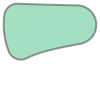

In [31]:
exposed_area_64kt = create_wind_buffers(
    truncated_cone_64kt, filtered_wind_contours_64kt
)
exposed_area_64kt

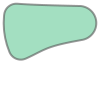

In [32]:
exposed_area_48kt

In [33]:
adm1 = adm2.dissolve(by="ADM1_PT")
overlapping_districts_64kt = adm2[adm2.intersects(exposed_area_64kt)]
district_names_64kt = overlapping_districts_64kt["ADM2_PT"].tolist()
district_list_str_64kt = "\n".join(district_names_64kt)
overlapping_districts_48kt = adm2[adm2.intersects(exposed_area_48kt)]
district_names_48kt = overlapping_districts_48kt["ADM2_PT"].tolist()
district_list_str_48kt = "\n".join(district_names_48kt)

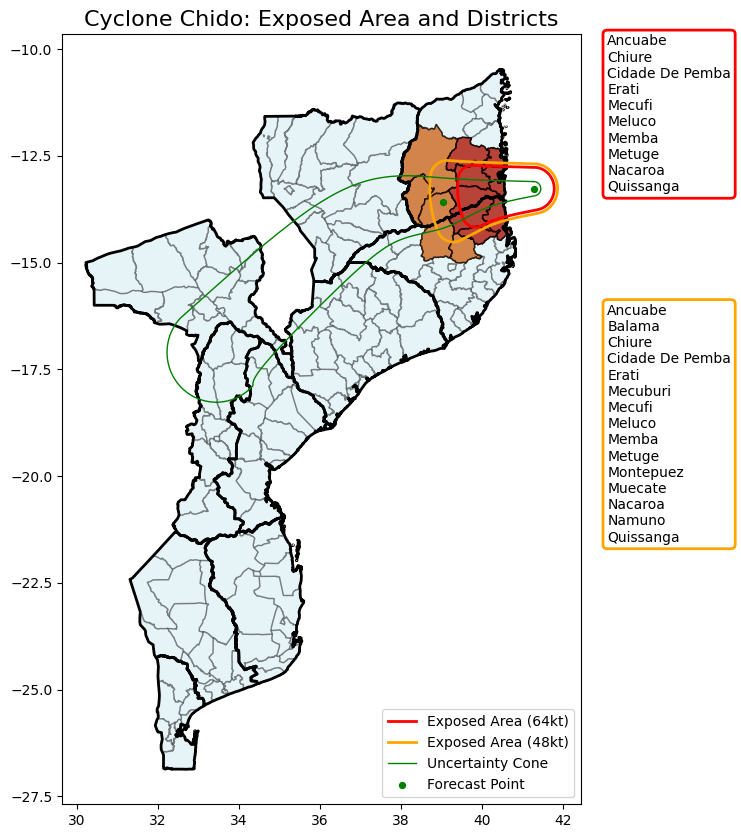

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
adm2.plot(ax=ax, color="lightblue", edgecolor="black", alpha=0.3)
# ax.plot(
#    *truncated_cone.exterior.xy,
#    color="blue",
#    linewidth=2.5,
#    label="Truncated Uncertainty Cone",
# )
ax.plot(
    *exposed_area_64kt.exterior.xy,
    color="red",
    linewidth=2,
    label="Exposed Area (64kt)",
)
ax.plot(
    *exposed_area_48kt.exterior.xy,
    color="orange",
    linewidth=2,
    label="Exposed Area (48kt)",
)
ax.plot(
    *cone_polygon.exterior.xy,
    color="green",
    linewidth=1,
    label="Uncertainty Cone",
)

overlapping_districts_48kt.plot(
    ax=ax, color="#CC5500", edgecolor="black", alpha=0.7
)
overlapping_districts_64kt.plot(
    ax=ax, color="#AD2831", edgecolor="black", alpha=0.7
)
adm1.plot(ax=ax, color="none", edgecolor="black", linewidth=2)
ax.scatter(
    cyclone_center.x,
    cyclone_center.y,
    color="green",
    s=18,
    label="Forecast Point",
)
ax.scatter(
    next_forecast_point.x,
    next_forecast_point.y,
    color="green",
    s=18,
)
ax.set_title("Cyclone Chido: Exposed Area and Districts", fontsize=16)

bbox_props_64kt = dict(
    boxstyle="round,pad=0.3", facecolor="white", edgecolor="red", lw=2
)
bbox_props_48kt = dict(
    boxstyle="round,pad=0.3", facecolor="white", edgecolor="orange", lw=2
)
ax.text(
    1.05,
    1,
    district_list_str_64kt,
    ha="left",
    va="top",
    transform=ax.transAxes,
    fontsize=10,
    bbox=bbox_props_64kt,
)
ax.text(
    1.05,
    0.65,
    district_list_str_48kt,
    ha="left",
    va="top",
    transform=ax.transAxes,
    fontsize=10,
    bbox=bbox_props_48kt,
)
ax.legend(loc="lower right", fontsize=10)
plt.show()